In [1]:
import sys
# path to steric_simulator module relative to notebook
#sys.path.append("../")

import copy
from reaction_network import ReactionNetwork
from reaction_network import gtostr
from vectorized_rxn_net import VectorizedRxnNet 
from vec_sim import VecSim
#from vec_kinsim import VecKinSim
from optimizer import Optimizer
#from EqSolver import EquilibriumSolver
from trap_metric import TrapMetric

import networkx as nx
import torch
from torch import DoubleTensor as Tensor

import matplotlib.pyplot as plt
import numpy as np

from compute_trap_factor import ComputeTrapFactor

In [4]:

optim_tau=[]
taus=[]
optims=[]

sizes=['trimer']#,'pentamer','esamer','heptamer']
for i,size in enumerate(sizes):
    base_input = f'input_files/ring_{size}_dG_{20}_rategrowth.pwr'

    rn = ReactionNetwork(base_input, one_step=True)
    rn.resolve_tree()
     
    uid_dict = {}
    
    for n in rn.network.nodes():
        for k,v in rn.network[n].items():
            uid = v['uid']
            r1 = set(gtostr(rn.network.nodes[n]['struct']))
            p = set(gtostr(rn.network.nodes[k]['struct']))
            r2 = p-r1
            reactants = (r1,r2)
            uid_dict[(n,k)] = uid

    
    #Changin k_on
    new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
    new_kon = new_kon + Tensor([1.]*np.array(2e0))

    update_kon_dict = {}
    for edge in rn.network.edges:
        #print(rn.network.get_edge_data(edge[0],edge[1]))
        update_kon_dict[edge] = new_kon[uid_dict[edge]]

    nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

    vec_rn = VectorizedRxnNet(rn, dev='cpu')
    
    
    vec_rn.reset(reset_params=True)

    optim = Optimizer(reaction_network=rn,
                    sim_runtime=1,
                    optim_iterations=500,
                    learning_rate=1e-1,
                    device='cpu',method="Adam")
    #---------------------------------
    
    labels=nx.get_node_attributes(rn.network, 'struct')
    nodes_list_2 = [gtostr(labels[key]) for key in labels.keys()]
    longest_name = max(nodes_list_2, key=len)
    indx = nodes_list_2.index(longest_name)     
    
    optim.rn.update_reaction_net(rn)
    optim.optimize(conc_scale=1,conc_thresh=1e-1,mod_bool=True,optim='time',yield_species=indx)
    optims.append(optim)
    
    final_t95 = np.array(optim.final_t95)
    optim_tau.append(final_t95)
        
    

Reaction Network Completed
Reaction rates:  tensor([2., 2., 2., 2., 2., 2.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([-20., -20., -20., -40., -40., -40.], dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100.,   0.,   0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu
Reaction rates:  tensor([2., 2., 2., 2., 2., 2.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([-20., -20., -20., -40., -40., -40.], dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100.,   0.,   0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu
Reaction Parameters before optimization: 
[Parameter containing:
tensor([2., 2.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)>
Using CPU
Time-based optimization
Yield has not reached 95 %. Increasing simulation time
Yield has not

In [6]:
optims[0].observable()

AttributeError: 'Optimizer' object has no attribute 'observable'

monomer


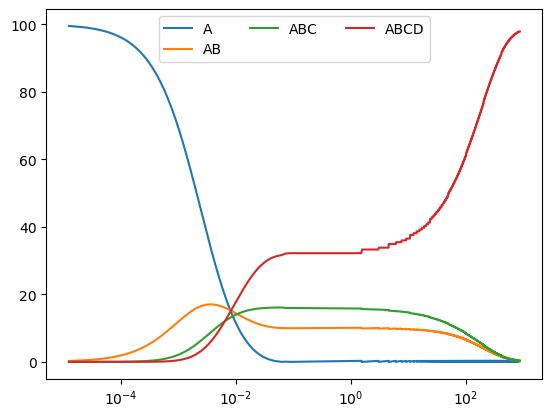

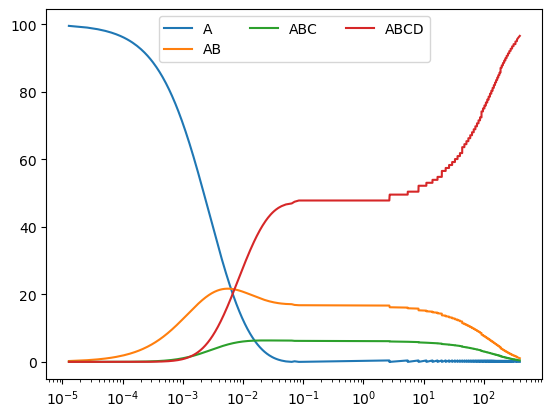

In [5]:
for i,optim in enumerate(optims):
    nodes_list = ['A','AB','ABC','ABCD','ABCDE','ABCDEF','ABCDEFG']
    nodes_list_names=['monomer','dimer','trimer','tetramer','pentamer','esamer','heptamer']
    
    print(f'{nodes_list_names[i]}')
    fig, ax = plt.subplots()
    optim.plot_observable(0,nodes_list,ax=ax)
    ax.set_xscale("log")
    
    fig, ax = plt.subplots()
    optim.plot_observable(-1,nodes_list,ax=ax)
    ax.set_xscale("log")

